In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In this example we are going to train an image classifier with the [EuroSAT](https://github.com/phelber/EuroSAT) dataset.

In [34]:
# RGB version

from pytorch_eo.datasets.eurosat import EuroSATRGB, EuroSAT

ds = EuroSATRGB(batch_size=25)
#ds = EuroSAT(batch_size=25, bands=(3,2,1))

ds.setup()

data already downloaded !
data already extracted !
Number of images: 27000
training samples 17280
validation samples 4320
test samples 5400


In [35]:
ds.classes

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [36]:
imgs, labels = next(iter(ds.train_dataloader()))

imgs.shape, labels.shape, imgs.dtype, imgs.max(), imgs.min()

(torch.Size([25, 3, 64, 64]),
 torch.Size([25]),
 torch.float32,
 tensor(1.),
 tensor(0.0784))

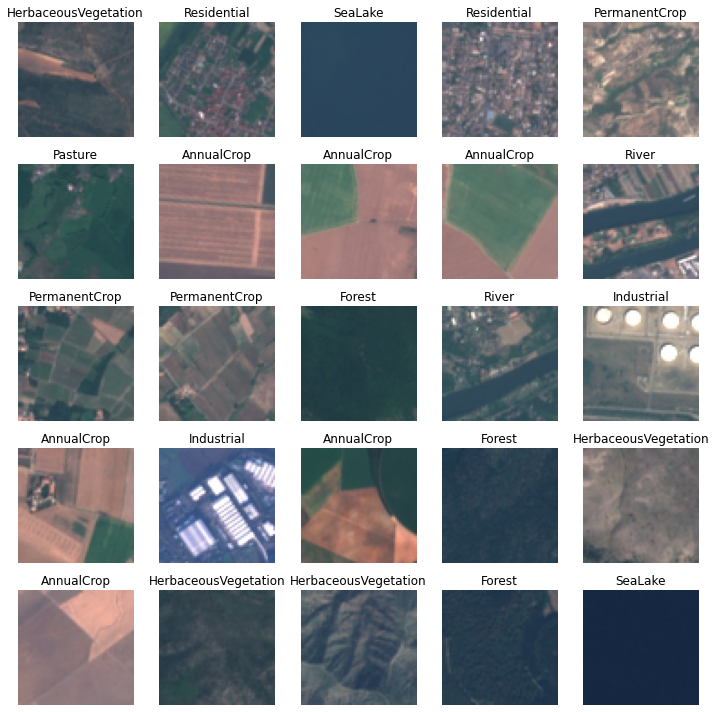

In [37]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
for i, (img, label) in enumerate(zip(imgs, labels)):
    ax = plt.subplot(5, 5, i + 1)
    ax.imshow(img.permute(1,2,0))
    ax.set_title(ds.classes[label.item()])
    ax.axis('off')
plt.tight_layout()
plt.show()

In [38]:
from pytorch_eo.tasks.classification import ImageClassifier

model = ImageClassifier(
	backbone='resnet18',
	in_chans=ds.in_chans,
	num_classes=ds.num_classes,
	pretrained=False
)

out = model(imgs)

out.shape, out.dtype, labels.shape, labels.dtype 

(torch.Size([25, 10]), torch.float32, torch.Size([25]), torch.int64)

In [39]:
import pytorch_lightning as pl

ds = EuroSATRGB(batch_size=1024)

model = ImageClassifier(
	backbone='resnet18',
	in_chans=ds.in_chans,
	num_classes=ds.num_classes,
	pretrained=True, 
)

trainer = pl.Trainer(
    gpus=1,
    precision=16,
    max_epochs=3,
)

trainer.fit(model, ds)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Using native 16bit precision.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type   | Params
---------------------------------
0 | model | ResNet | 11.2 M
---------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)


data already downloaded !
data already extracted !
Number of images: 27000
training samples 17280
validation samples 4320
test samples 5400


/home/juan/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/juan/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


In [40]:
trainer.test()

data already downloaded !
data already extracted !


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Number of images: 27000
training samples 17280
validation samples 4320
test samples 5400


/home/juan/miniconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.8490740656852722}
--------------------------------------------------------------------------------


[{'test_acc': 0.8490740656852722}]

In [41]:
import torch 

imgs, labels = next(iter(ds.test_dataloader()))

preds = model.predict(imgs)
preds = torch.argmax(preds, axis=1)
preds

tensor([0, 4, 0,  ..., 6, 1, 8])

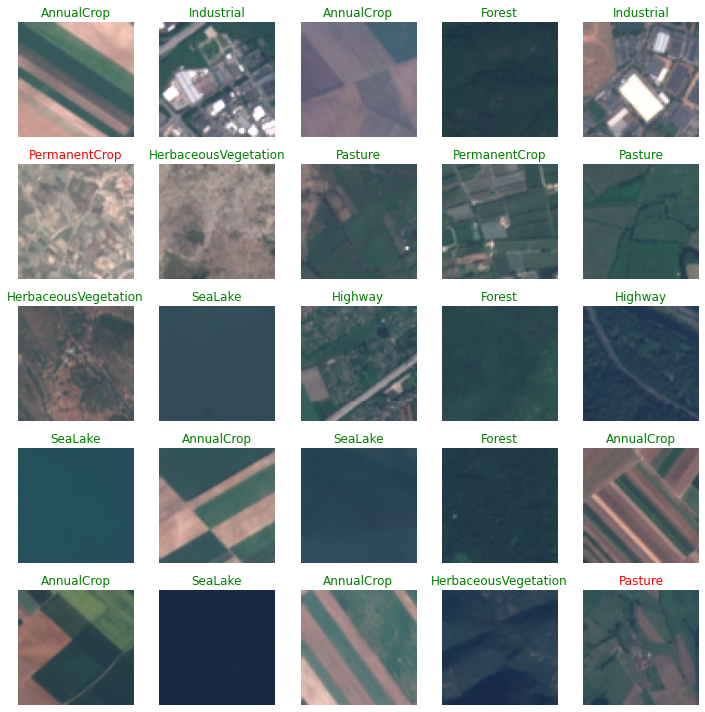

In [42]:

fig = plt.figure(figsize=(10, 10))
for i, (img, label, pred) in enumerate(zip(imgs[:25], labels[:25], preds[:25])):
	ax = plt.subplot(5, 5, i + 1)
	ax.imshow(img.permute(1,2,0))
	gt = ds.classes[label.item()]
	pred = ds.classes[pred.item()]
	ax.set_title(gt, color="green" if gt == pred else 'red')
	ax.axis('off')
plt.tight_layout()
plt.show()